# Problem 5 — Q-learning on FrozenLake

Environment: 4x4 | States: 16, Actions: 4
Episode 100/5000 | Last100 avg: 0.020 | Epsilon: 0.606 | Max Q: 0.32
Episode 200/5000 | Last100 avg: 0.120 | Epsilon: 0.367 | Max Q: 0.96
Episode 300/5000 | Last100 avg: 0.380 | Epsilon: 0.222 | Max Q: 0.97
Episode 400/5000 | Last100 avg: 0.590 | Epsilon: 0.135 | Max Q: 0.99
Episode 500/5000 | Last100 avg: 0.790 | Epsilon: 0.082 | Max Q: 1.00
Episode 600/5000 | Last100 avg: 0.860 | Epsilon: 0.049 | Max Q: 0.98
Episode 700/5000 | Last100 avg: 0.870 | Epsilon: 0.030 | Max Q: 1.00
Episode 800/5000 | Last100 avg: 0.960 | Epsilon: 0.018 | Max Q: 1.00
Episode 900/5000 | Last100 avg: 0.970 | Epsilon: 0.011 | Max Q: 1.00
Episode 1000/5000 | Last100 avg: 0.990 | Epsilon: 0.010 | Max Q: 1.00
Episode 1100/5000 | Last100 avg: 1.000 | Epsilon: 0.010 | Max Q: 1.00
Episode 1200/5000 | Last100 avg: 0.980 | Epsilon: 0.010 | Max Q: 1.00
Episode 1300/5000 | Last100 avg: 0.980 | Epsilon: 0.010 | Max Q: 1.00
Episode 1400/5000 | Last100 avg: 0.990 | Epsilon: 0.010 |

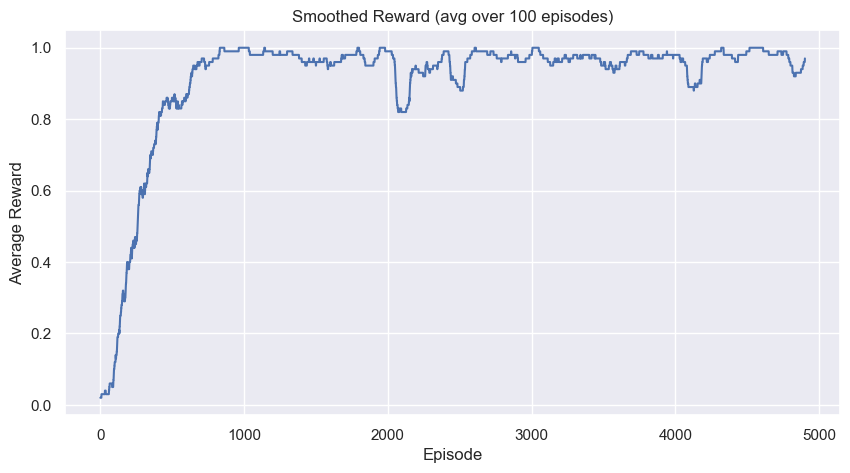

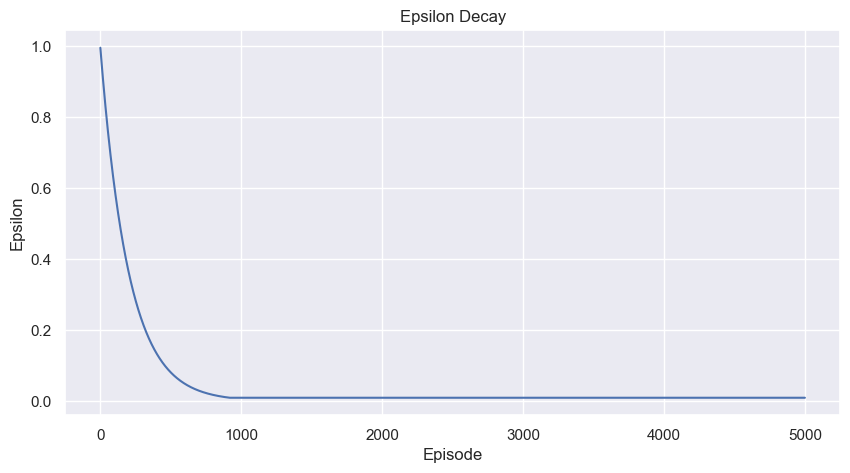

In [2]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
CONFIG = {
    'env_name': 'FrozenLake-v1',
    'map_name': '4x4',            # Change to '8x8' for a harder map
    'is_slippery': True,          # Set to False for deterministic map
    'alpha': 0.3,                 # Learning rate
    'gamma': 0.99,                # Discount factor
    'epsilon': 1.0,               # Starting exploration rate
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995,
    'episodes': 5000,             # Training episodes
    'max_steps': 100,             # Max steps per episode
    'seed': 42
}

# --- Set seeds for reproducibility ---
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# --- Initialize environment ---
env = gym.make(CONFIG['env_name'], map_name=CONFIG['map_name'], is_slippery=CONFIG['is_slippery'])
env.reset(seed=CONFIG['seed'])
n_states = env.observation_space.n
n_actions = env.action_space.n
print(f"Environment: {CONFIG['map_name']} | States: {n_states}, Actions: {n_actions}")

# --- Q-Learning Agent ---
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.Q = np.zeros((n_states, n_actions))

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            return np.argmax(self.Q[state])

    def update(self, s, a, r, s_next, done):
        best_next = np.max(self.Q[s_next])
        target = r + (0 if done else self.gamma * best_next)
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

agent = QLearningAgent(
    n_states, n_actions,
    CONFIG['alpha'], CONFIG['gamma'],
    CONFIG['epsilon'], CONFIG['epsilon_min'],
    CONFIG['epsilon_decay']
)

# --- Training Loop ---
rewards_per_episode = []
epsilons = []

for episode in range(CONFIG['episodes']):
    state, _ = env.reset(seed=CONFIG['seed'])
    total_reward = 0

    for step in range(CONFIG['max_steps']):
        action = agent.choose_action(state)
        next_state, reward, done, truncated, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done or truncated:
            break

    agent.decay_epsilon()
    rewards_per_episode.append(total_reward)
    epsilons.append(agent.epsilon)

    # --- Live feedback every 100 episodes ---
    if (episode + 1) % 100 == 0:
        avg = np.mean(rewards_per_episode[-100:])
        print(f"Episode {episode + 1}/{CONFIG['episodes']} | "
              f"Last100 avg: {avg:.3f} | "
              f"Epsilon: {agent.epsilon:.3f} | "
              f"Max Q: {agent.Q.max():.2f}")

print("\nTraining completed ✅")

# --- Quick Evaluation (greedy policy) ---
n_eval_episodes = 100
successes = 0
steps_list = []

for _ in range(n_eval_episodes):
    state, _ = env.reset(seed=CONFIG['seed'])
    for step in range(CONFIG['max_steps']):
        action = np.argmax(agent.Q[state])
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        if done or truncated:
            if reward > 0:
                successes += 1
            steps_list.append(step + 1)
            break

success_rate = successes / n_eval_episodes
print(f"Evaluation over {n_eval_episodes} episodes:")
print(f"  Success rate: {success_rate*100:.1f}%")
print(f"  Avg steps (successful episodes): {np.mean(steps_list) if steps_list else 0:.2f}")

# --- Inspect learned Q-table ---
print("\nSample Q-values (first 10 states):")
print(agent.Q[:10])

# --- Plot learning progress ---
sns.set(style="darkgrid")
window = 100
smoothed_rewards = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards)
plt.title("Smoothed Reward (avg over 100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epsilons)
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()